In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skopt import BayesSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, QuantileTransformer

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_bikes = pd.read_csv('../data/availability.csv')
df_bikes['time_stamp'] = pd.to_datetime(df_bikes['time_stamp']).dt.round('D')
df_bikes = df_bikes.groupby(['id', 'time_stamp']).agg({'bikes': 'mean', 'bike_stands': 'mean'}).reset_index()

In [3]:
def round_nearest(value):
    integer_part = int(value)
    fractional_part = value - integer_part
    if fractional_part >= 0.5:
        return integer_part + 1
    else:
        return integer_part

In [4]:
df_bikes['bikes'] = df_bikes['bikes'].apply(lambda x: round_nearest(x))
df_bikes['bike_stands'] = df_bikes['bike_stands'].apply(lambda x: round_nearest(x))
df_bikes = df_bikes[df_bikes['time_stamp'] != '2024-03-01']

In [5]:
df_bikes.head()

,id,time_stamp,bikes,bike_stands
0,1,2024-01-01,24,7
1,1,2024-01-02,19,12
2,1,2024-01-03,5,26
3,1,2024-01-04,3,28
4,1,2024-01-05,11,20


In [6]:
df_bikes.tail()

,id,time_stamp,bikes,bike_stands
6948,117,2024-02-25,23,18
6949,117,2024-02-26,26,14
6950,117,2024-02-27,18,22
6951,117,2024-02-28,9,31
6952,117,2024-02-29,7,33


In [7]:
len(df_bikes)

6840

In [8]:
df_weather = pd.read_csv('../data/dailyWeather.csv')
df_weather['time_stamp'] = pd.to_datetime(df_weather['time_stamp']).dt.round('D')

In [9]:

df_weather['sunrise'] = pd.to_datetime(df_weather['sunrise']).dt.time
df_weather['sunset'] = pd.to_datetime(df_weather['sunset']).dt.time
df_weather.head()

,time_stamp,maxtemp_c,mintemp_c,avgtemp_c,maxwind_kph,totalprecip_mm,avgvis_km,avghumidity,uv,sunrise,sunset
0,2024-01-01,10.4,3.8,6.4,30.1,5.391,15.5,86.9,0.0,08:40:26,16:16:31
1,2024-01-02,9.9,6.8,8.5,28.8,6.060,14.7,89.7,0.0,08:40:17,16:17:38
2,2024-01-03,8.1,6.7,7.3,24.2,0.375,16.7,90.7,1.0,08:40:04,16:18:48
3,2024-01-04,7.1,4.1,5.6,24.2,0.005,18.7,85.9,2.0,08:39:47,16:20:00
4,2024-01-05,6.9,2.1,4.0,25.4,0.005,14.6,92.1,2.0,08:39:27,16:21:16


In [10]:
len(df_weather) * 114

6840

In [11]:
df = pd.merge(df_bikes, df_weather, on='time_stamp', how='inner')
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

df['sunrise'] = df['sunrise'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
df['sunset'] = df['sunset'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

df.head()

,id,time_stamp,bikes,bike_stands,maxtemp_c,mintemp_c,avgtemp_c,maxwind_kph,totalprecip_mm,avgvis_km,avghumidity,uv,sunrise,sunset
0,1,2024-01-01,24,7,10.4,3.8,6.4,30.1,5.391,15.5,86.9,0.0,31226,58591
1,1,2024-01-02,19,12,9.9,6.8,8.5,28.8,6.060,14.7,89.7,0.0,31217,58658
2,1,2024-01-03,5,26,8.1,6.7,7.3,24.2,0.375,16.7,90.7,1.0,31204,58728
3,1,2024-01-04,3,28,7.1,4.1,5.6,24.2,0.005,18.7,85.9,2.0,31187,58800
4,1,2024-01-05,11,20,6.9,2.1,4.0,25.4,0.005,14.6,92.1,2.0,31167,58876


### ARIMA

In [12]:
ts_df = df.drop('bike_stands', axis=1)
ts_df = ts_df[ts_df['id'] == 1]
ts_df = ts_df.drop('id', axis=1)
ts_df['time_stamp'] = pd.to_datetime(ts_df['time_stamp'])
ts_df = ts_df.set_index('time_stamp')
exog_data = ts_df[['maxtemp_c', 'mintemp_c', 'avgtemp_c', 'maxwind_kph', 'totalprecip_mm', 'avgvis_km', 'avghumidity', 'uv', 'sunrise', 'sunset']]
ts_df.head()

,bikes,maxtemp_c,mintemp_c,avgtemp_c,maxwind_kph,totalprecip_mm,avgvis_km,avghumidity,uv,sunrise,sunset
time_stamp,,,,,,,,,,,
2024-01-01,24,10.4,3.8,6.4,30.1,5.391,15.5,86.9,0.0,31226,58591
2024-01-02,19,9.9,6.8,8.5,28.8,6.060,14.7,89.7,0.0,31217,58658
2024-01-03,5,8.1,6.7,7.3,24.2,0.375,16.7,90.7,1.0,31204,58728
2024-01-04,3,7.1,4.1,5.6,24.2,0.005,18.7,85.9,2.0,31187,58800
2024-01-05,11,6.9,2.1,4.0,25.4,0.005,14.6,92.1,2.0,31167,58876


In [13]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Number Of Values Used For ADF Regression and Critical Values Calculation : ", dftest[3])
    print("5. Critical Values : ", dftest[0])
    for key, val in dftest[4].items():
        print("\t", key, " : ", val)

In [14]:
ad_test(ts_df['bikes'])

1. ADF :  -6.3593243404661
2. P-Value :  2.4970358357081105e-08
3. Num Of Lags :  0
4. Number Of Values Used For ADF Regression and Critical Values Calculation :  59
5. Critical Values :  -6.3593243404661
	 1%  :  -3.5463945337644063
	 5%  :  -2.911939409384601
	 10%  :  -2.5936515282964665


In [15]:
from pmdarima import auto_arima

In [16]:
stepwise_fit = auto_arima(ts_df['bikes'], exogenous=exog_data, trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=396.349, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=401.242, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=400.629, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=400.433, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=481.781, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=404.091, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=402.585, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=398.293, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=401.563, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=402.416, Time=0.01 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=402.979, Time=0.03 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=400.477, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fi

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -192.175
Date:                Wed, 20 Mar 2024   AIC                            396.349
Time:                        15:28:08   BIC                            408.915
Sample:                    01-01-2024   HQIC                           401.265
                         - 02-29-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.0383      0.886     10.206      0.000       7.303      10.774
ar.L1          1.1960      0.038     31.424      0.000       1.121       1.271
ar.L2         -0.9851      0.030    -32.338      0.000      -1.045      -0.925
ma.L1         -1.1033      0.135     -8.173      0.000      -1.368      -0.839
ma.L2          0.9574      0.199      4.805      0.000       0.567       1.348
sigma2        33.7443      9.293      3.631      0.000      15.531      51.957
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.98
Prob(Q):                              0.97   Prob(JB):                         0.61
Heteroskedasticity (H):               1.08   Skew:                             0.30
Prob(H) (two-sided):                  0.87   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
from statsmodels.tsa.arima.model import ARIMA

In [18]:
print(ts_df.shape)
train = ts_df.iloc[:-30]
test = ts_df.iloc[-30:]
print(train.shape, test.shape)

exog_train = train[['maxtemp_c', 'mintemp_c', 'avgtemp_c', 'maxwind_kph', 'totalprecip_mm', 'avgvis_km', 'avghumidity', 'uv', 'sunrise', 'sunset']]
exog_test = test[['maxtemp_c', 'mintemp_c', 'avgtemp_c', 'maxwind_kph', 'totalprecip_mm', 'avgvis_km', 'avghumidity', 'uv', 'sunrise', 'sunset']]

(60, 11)
(30, 11) (30, 11)


In [19]:
model = ARIMA(train['bikes'], order=(2, 0, 2), exog=exog_train)
model = model.fit()
model.summary()

/Users/musaddique33/anaconda3/envs/comp30830/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/musaddique33/anaconda3/envs/comp30830/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/musaddique33/anaconda3/envs/comp30830/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/musaddique33/anaconda3/envs/comp30830/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  bikes   No. Observations:                   30
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 -84.960
Date:                Wed, 20 Mar 2024   AIC                            201.920
Time:                        15:28:08   BIC                            224.339
Sample:                    01-01-2024   HQIC                           209.092
                         - 01-30-2024                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           3878.8838      0.025   1.56e+05      0.000    3878.835    3878.932
maxtemp_c         -0.0093      2.552     -0.004      0.997      -5.011       4.993
mintemp_c         -0.2942      2.187     -0.135      0.893      -4.580       3.992
avgtemp_c         -0.7715      4.348     -0.177      0.859      -9.294       7.751
maxwind_kph        0.3414      0.377      0.907      0.365      -0.397       1.079
totalprecip_mm    -0.4631      1.063     -0.436      0.663      -2.547       1.621
avgvis_km         -1.0470      0.807     -1.297      0.194      -2.629       0.535
avghumidity       -0.3000      0.597     -0.503      0.615      -1.470       0.870
uv                -0.8143      3.406     -0.239      0.811      -7.490       5.862
sunrise           -0.0578      0.003    -21.781      0.000      -0.063      -0.053
sunset            -0.0344      0.001    -28.928      0.000      -0.037      -0.032
ar.L1              0.2890      0.659      0.439      0.661      -1.002       1.580
ar.L2             -0.2408      0.553     -0.436      0.663      -1.324       0.842
ma.L1             -0.2227      0.791     -0.281      0.778      -1.774       1.328
ma.L2             -0.4747      0.869     -0.547      0.585      -2.177       1.228
sigma2            18.8359      8.587      2.193      0.028       2.005      35.667
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.99
Prob(Q):                              0.97   Prob(JB):                         0.61
Heteroskedasticity (H):               1.85   Skew:                             0.35
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.29e+18. Standard errors may be unstable.
"""

In [20]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.forecast(steps=len(test), exog=exog_test, typ='linear')
pred.index = ts_df.index[start:end+1]
print(pred)

time_stamp
2024-01-31     20.992571
2024-02-01     17.818591
2024-02-02     14.283676
2024-02-03     20.830444
2024-02-04     23.881923
2024-02-05     22.924041
2024-02-06     26.807282
2024-02-07     26.481872
2024-02-08     37.737090
2024-02-09     38.287065
2024-02-10     37.153379
2024-02-11     42.182766
2024-02-12     41.803452
2024-02-13     38.944874
2024-02-14     40.272496
2024-02-15     39.799832
2024-02-16     51.243543
2024-02-17     50.436236
2024-02-18     52.441554
2024-02-19     63.284997
2024-02-20     63.210451
2024-02-21     70.504417
2024-02-22     74.535635
2024-02-23     76.252326
2024-02-24     76.609973
2024-02-25     85.059877
2024-02-26     86.545764
2024-02-27     96.893632
2024-02-28     98.338696
2024-02-29    109.574848
Name: predicted_mean, dtype: float64


<Axes: xlabel='time_stamp'>

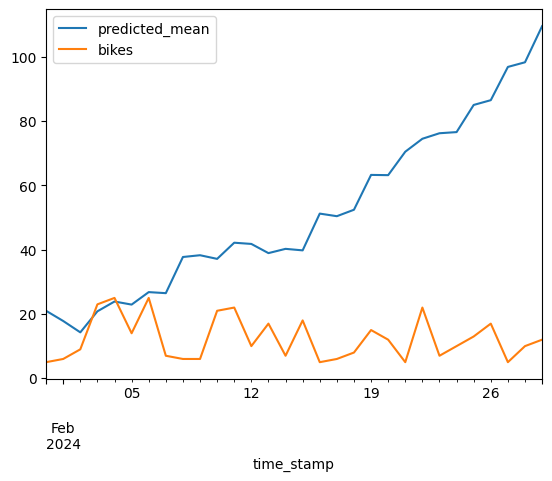

In [21]:
pred.plot(legend=True)
test['bikes'].plot(legend=True)

#

In [22]:
df['date_only'] = df['time_stamp'].dt.day
df['day_of_week'] = df['time_stamp'].dt.dayofweek
df = df.drop('time_stamp', axis=1)
df.head()

,id,bikes,bike_stands,maxtemp_c,mintemp_c,avgtemp_c,maxwind_kph,totalprecip_mm,avgvis_km,avghumidity,uv,sunrise,sunset,date_only,day_of_week
0,1,24,7,10.4,3.8,6.4,30.1,5.391,15.5,86.9,0.0,31226,58591,1,0
1,1,19,12,9.9,6.8,8.5,28.8,6.060,14.7,89.7,0.0,31217,58658,2,1
2,1,5,26,8.1,6.7,7.3,24.2,0.375,16.7,90.7,1.0,31204,58728,3,2
3,1,3,28,7.1,4.1,5.6,24.2,0.005,18.7,85.9,2.0,31187,58800,4,3
4,1,11,20,6.9,2.1,4.0,25.4,0.005,14.6,92.1,2.0,31167,58876,5,4


In [23]:
X = df[['id', 'maxtemp_c', 'mintemp_c', 'avgtemp_c', 'maxwind_kph', 'totalprecip_mm', 'avgvis_km', 'avghumidity', 'uv', 'sunrise', 'sunset', 'date_only', 'day_of_week']]
y = df[['bikes', 'bike_stands']]

In [24]:
X.head()

,id,maxtemp_c,mintemp_c,avgtemp_c,maxwind_kph,totalprecip_mm,avgvis_km,avghumidity,uv,sunrise,sunset,date_only,day_of_week
0,1,10.4,3.8,6.4,30.1,5.391,15.5,86.9,0.0,31226,58591,1,0
1,1,9.9,6.8,8.5,28.8,6.060,14.7,89.7,0.0,31217,58658,2,1
2,1,8.1,6.7,7.3,24.2,0.375,16.7,90.7,1.0,31204,58728,3,2
3,1,7.1,4.1,5.6,24.2,0.005,18.7,85.9,2.0,31187,58800,4,3
4,1,6.9,2.1,4.0,25.4,0.005,14.6,92.1,2.0,31167,58876,5,4


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
def model_performance_trees(regrssor, output, algorithm, X_train=X_train, X_test=X_test):
    regrssor.fit(X_train, y_train[output])
    y_pred = regrssor.predict(X_test)
    print(algorithm, "\t", output)
    mae = mean_absolute_error(y_test[output], y_pred)
    print("MAE : ", mae)
    mse = mean_squared_error(y_test[output], y_pred)
    print("MSE : ", mse)
    r2 = r2_score(y_test[output], y_pred)
    print("R-squared : ", r2)

    plt.scatter(y_test[output], y_pred, marker='.', color='blue' ,edgecolors='red', s=70)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Validation Set Predictions vs. Actual Values')
    plt.show()

In [27]:
def BayesSearch(model, param_space, output, X_train=X_train):
    bayes_search = BayesSearchCV(
        estimator=model,
        search_spaces=param_space,
        scoring='neg_mean_squared_error',
        cv=3,
        n_jobs=-1
    )
    bayes_search.fit(X_train, y_train[output])
    best_params = bayes_search.best_params_
    print("Best parameters found:", best_params)

### XGBoost

In [28]:
from xgboost import XGBRegressor

In [29]:
param_space = {
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'max_depth': (3, 10),
    'n_estimators': (100, 500),
    'min_child_weight': (1, 10),
    'gamma': (0.0, 1.0, 'uniform'),
    'subsample': (0.5, 1.0, 'uniform'),
    'colsample_bytree': (0.5, 1.0, 'uniform')
}

# regressor_xgb = XGBRegressor()
# BayesSearch(regressor_xgb, param_space, 'bikes')

Best parameters found: OrderedDict({'colsample_bytree': 0.5728224722899247, 'gamma': 1.0, 'learning_rate': 0.09001216654162925, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 454, 'subsample': 1.0})

In [30]:
# regressor_xgb = XGBRegressor()
# BayesSearch(regressor_xgb, param_space, 'bike_stands')

Best parameters found: OrderedDict({'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.0738515765897682, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.9238487201755751})

XGBoost 	 bikes
MAE :  4.242344945233468
MSE :  29.424055669788608
R-squared :  0.5455626689771114


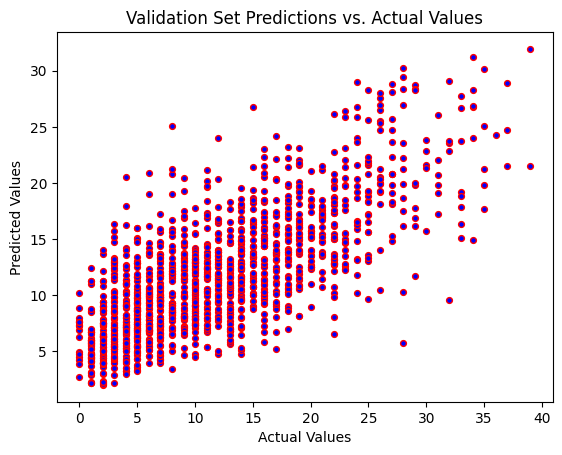

In [31]:
model_xgb = XGBRegressor(colsample_bytree=0.5728224722899247, 
                         gamma=1.0, 
                         learning_rate=0.09001216654162925, 
                         max_depth=5, 
                         min_child_weight=10, 
                         n_estimators=454, 
                         subsample=1.0)
model_performance_trees(model_xgb, 'bikes', 'XGBoost')

XGBoost 	 bike_stands
MAE :  4.210204276947947
MSE :  28.995187405400557
R-squared :  0.6810211726521073


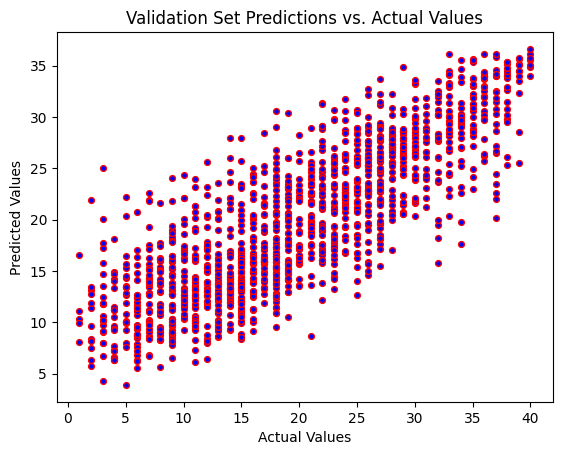

In [32]:
model_xgb2 = XGBRegressor(colsample_bytree=0.5, 
                          gamma=0.0, 
                          learning_rate=0.0738515765897682, 
                          max_depth=5, 
                          min_child_weight=1, 
                          n_estimators=500, 
                          subsample=0.9238487201755751)

model_performance_trees(model_xgb2, 'bike_stands', 'XGBoost')

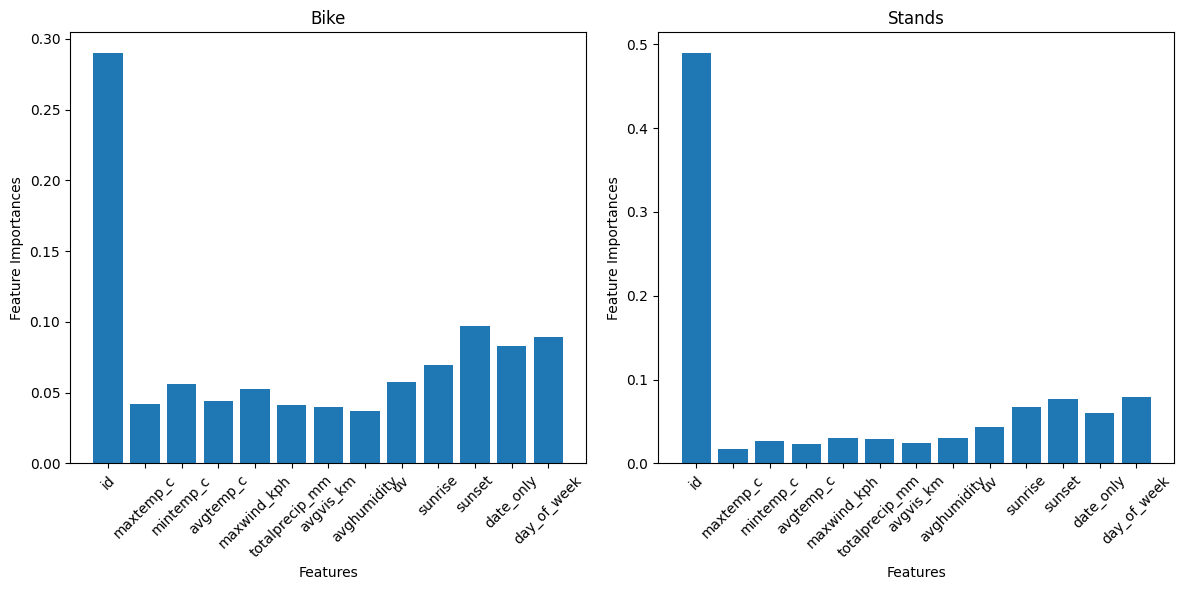

In [33]:
feature_importances_rf2 = model_xgb2.feature_importances_
feature_importances_rf1 = model_xgb.feature_importances_
features = X_train.columns

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(features, feature_importances_rf1)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Bike')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(features, feature_importances_rf2)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Stands')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [34]:
bikes = np.vectorize(round_nearest)(model_xgb.predict(X_test))
stands = np.vectorize(round_nearest)(model_xgb2.predict(X_test))
for i in range(10):
    print(f'Predicted: Bikes={bikes[i]}, Bike Stands={stands[i]} | Actual: Bikes={y_test['bikes'].values[i]}, Bike Stands={y_test['bike_stands'].values[i]}')

Predicted: Bikes=7, Bike Stands=28 | Actual: Bikes=9, Bike Stands=27
Predicted: Bikes=11, Bike Stands=29 | Actual: Bikes=13, Bike Stands=27
Predicted: Bikes=9, Bike Stands=19 | Actual: Bikes=8, Bike Stands=21
Predicted: Bikes=18, Bike Stands=21 | Actual: Bikes=26, Bike Stands=14
Predicted: Bikes=5, Bike Stands=35 | Actual: Bikes=11, Bike Stands=29
Predicted: Bikes=7, Bike Stands=16 | Actual: Bikes=4, Bike Stands=16
Predicted: Bikes=17, Bike Stands=10 | Actual: Bikes=17, Bike Stands=13
Predicted: Bikes=5, Bike Stands=16 | Actual: Bikes=3, Bike Stands=17
Predicted: Bikes=29, Bike Stands=11 | Actual: Bikes=24, Bike Stands=16
Predicted: Bikes=9, Bike Stands=28 | Actual: Bikes=8, Bike Stands=32


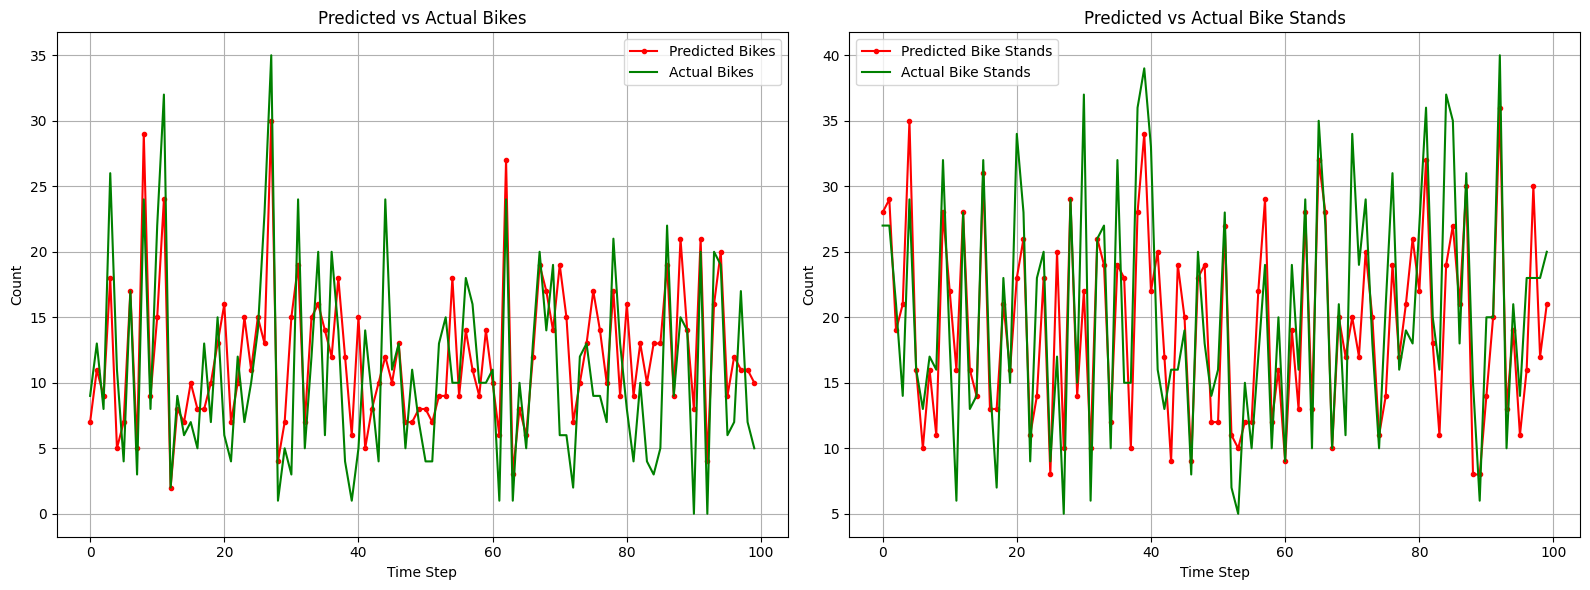

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(np.round(bikes)[:100], label='Predicted Bikes', color='red', marker='.')
axs[0].plot(np.round(y_test['bikes'].values)[:100], label='Actual Bikes', color='green')
axs[0].set_title('Predicted vs Actual Bikes')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(np.round(stands)[:100], label='Predicted Bike Stands', color='red', marker='.')
axs[1].plot(np.round(y_test['bike_stands'].values)[:100], label='Actual Bike Stands', color='green')
axs[1].set_title('Predicted vs Actual Bike Stands')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

#

In [36]:
def model_performance_non_bikes(regrssor, output, algorithm, X_train_processed, y_train_processed, preprocessor, scalar):
    regrssor.fit(X_train_processed, y_train_processed)
    y_pred = regrssor.predict(preprocessor.transform(X_test))
    
    print(algorithm, "\t", output)
    mae = mean_absolute_error(y_test[output], scalar.inverse_transform(y_pred.reshape(-1, 1)))
    print("MAE : ", mae)
    mse = mean_squared_error(y_test[output], scalar.inverse_transform(y_pred.reshape(-1, 1)))
    print("MSE : ", mse)
    r2 = r2_score(y_test[output], scalar.inverse_transform(y_pred.reshape(-1, 1)))
    print("R-squared : ", r2)

    plt.scatter(y_test[output], scalar.inverse_transform(y_pred.reshape(-1, 1)), marker='.', color='blue' ,edgecolors='red', s=70)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Validation Set Predictions vs. Actual Values')
    plt.show()


In [37]:
def BayesSearch_non_tree(model, param_space, y_train_processed, X_train_processed):
    bayes_search = BayesSearchCV(
        estimator=model,
        search_spaces=param_space,
        scoring='neg_mean_squared_error',
        cv=3,
        n_jobs=-1
    )
    bayes_search.fit(X_train_processed, y_train_processed)
    best_params = bayes_search.best_params_
    print("Best parameters found:", best_params)

### KNN

In [38]:
from sklearn.neighbors import KNeighborsRegressor

In [39]:
preprocessor_knn = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['maxtemp_c', 'mintemp_c', 'avgtemp_c', 'maxwind_kph', 'totalprecip_mm', 'avgvis_km', 'avghumidity', 'uv', 'sunrise', 'sunset', 'date_only', 'day_of_week']),
        ('cat', OneHotEncoder(), ['id'])
    ])
X_train_processed = preprocessor_knn.fit_transform(X_train)

In [40]:
scalar1 = StandardScaler()
y_train_processed1 = scalar1.fit_transform(y_train['bikes'].values.reshape(-1, 1))
scalar2 = StandardScaler()
y_train_processed2 = scalar2.fit_transform(y_train['bike_stands'].values.reshape(-1, 1))

In [41]:
param_space = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'p': [1, 2] 
}

# regressor_knn = KNeighborsRegressor()
# BayesSearch_non_tree(regressor_knn, param_space, y_train_processed1, X_train_processed)

Best parameters found: OrderedDict({'algorithm': 'brute', 'n_neighbors': 11, 'p': 2, 'weights': 'distance'})

In [42]:
# regressor_knn = KNeighborsRegressor()
# BayesSearch_non_tree(regressor_knn, param_space, y_train_processed2, X_train_processed)

Best parameters found: OrderedDict({'algorithm': 'ball_tree', 'n_neighbors': 11, 'p': 2, 'weights': 'distance'})

KNN 	 bikes
MAE :  6.859298055662852
MSE :  70.64820670425081
R-squared :  -0.09112023361202914


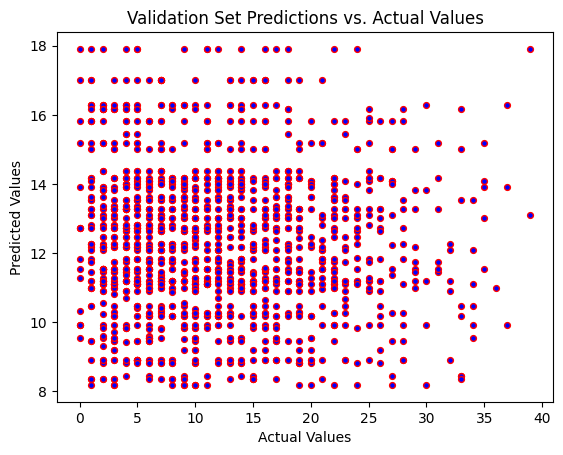

In [43]:
model_knn = KNeighborsRegressor(algorithm='ball_tree', n_neighbors=11, p=1, weights='distance')
model_performance_non_bikes(model_knn, 'bikes', 'KNN', X_train_processed, y_train_processed1, preprocessor_knn, scalar1)

KNN 	 bike_stands
MAE :  8.261677205296385
MSE :  97.04507653523555
R-squared :  -0.06760216032714084


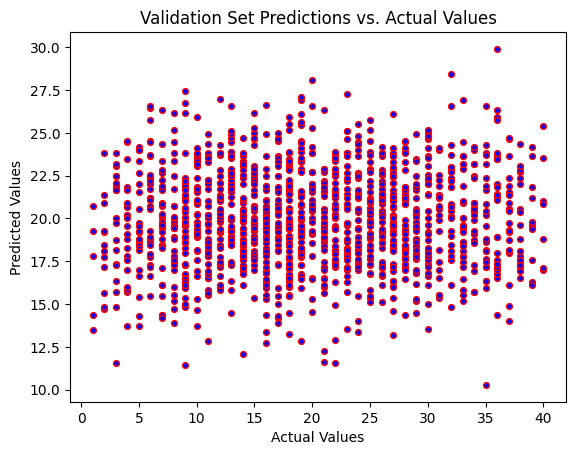

In [44]:
model_knn2 = KNeighborsRegressor(algorithm='ball_tree', n_neighbors=11, p=2, weights='distance')
model_performance_non_bikes(model_knn2, 'bike_stands', 'KNN', X_train_processed, y_train_processed2, preprocessor_knn, scalar2)

In [45]:
bikes = np.vectorize(round_nearest)(scalar1.inverse_transform(model_knn.predict(preprocessor_knn.transform(X_test))))
stands = np.vectorize(round_nearest)(scalar2.inverse_transform(model_knn2.predict(preprocessor_knn.transform(X_test))))
for i in range(10):
    print(f'Predicted: Bikes={np.round(bikes)[i]}, Bike Stands={np.round(stands)[i]} | Actual: Bikes={np.round(y_test['bikes'].values)[i]}, Bike Stands={np.round(y_test['bike_stands'].values)[i]}')

Predicted: Bikes=[10], Bike Stands=[20] | Actual: Bikes=9, Bike Stands=27
Predicted: Bikes=[12], Bike Stands=[21] | Actual: Bikes=13, Bike Stands=27
Predicted: Bikes=[9], Bike Stands=[17] | Actual: Bikes=8, Bike Stands=21
Predicted: Bikes=[11], Bike Stands=[19] | Actual: Bikes=26, Bike Stands=14
Predicted: Bikes=[14], Bike Stands=[18] | Actual: Bikes=11, Bike Stands=29
Predicted: Bikes=[14], Bike Stands=[16] | Actual: Bikes=4, Bike Stands=16
Predicted: Bikes=[12], Bike Stands=[24] | Actual: Bikes=17, Bike Stands=13
Predicted: Bikes=[14], Bike Stands=[18] | Actual: Bikes=3, Bike Stands=17
Predicted: Bikes=[13], Bike Stands=[18] | Actual: Bikes=24, Bike Stands=16
Predicted: Bikes=[10], Bike Stands=[23] | Actual: Bikes=8, Bike Stands=32


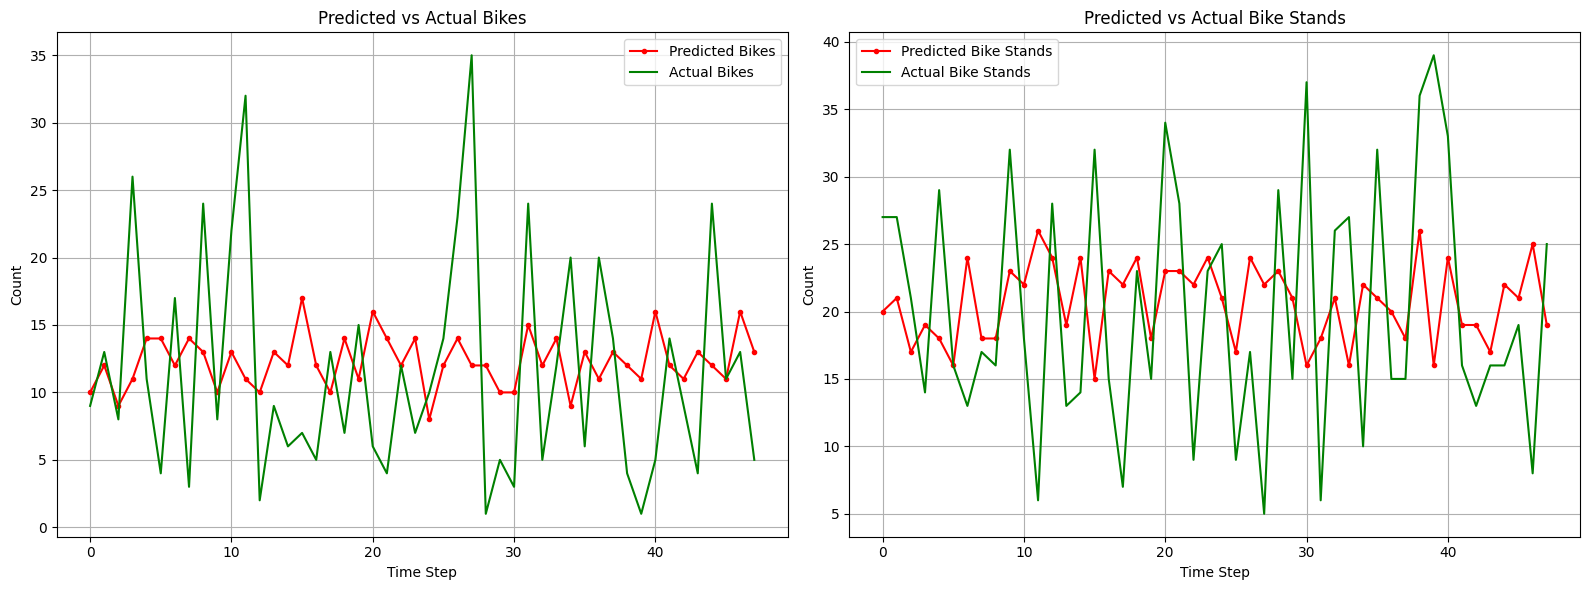

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(np.round(bikes)[:48], label='Predicted Bikes', color='red', marker='.')
axs[0].plot(np.round(y_test['bikes'].values)[:48], label='Actual Bikes', color='green')
axs[0].set_title('Predicted vs Actual Bikes')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(np.round(stands)[:48], label='Predicted Bike Stands', color='red', marker='.')
axs[1].plot(np.round(y_test['bike_stands'].values)[:48], label='Actual Bike Stands', color='green')
axs[1].set_title('Predicted vs Actual Bike Stands')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()

### Polynomial Regression

In [47]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [48]:
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

Poly-Regression 	 bikes
MAE :  6.536815735253131
MSE :  64.25788484508539
R-squared :  0.007574550093062515


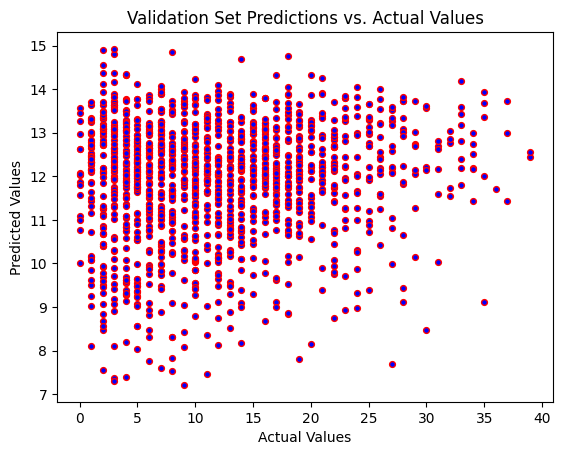

In [49]:
model_pr = LinearRegression()
model_performance_trees(model_pr, 'bikes', 'Poly-Regression', X_train_poly, X_test_poly)

Poly-Regression 	 bike_stands
MAE :  7.590761927902486
MSE :  82.79590491907275
R-squared :  0.08915433823426921


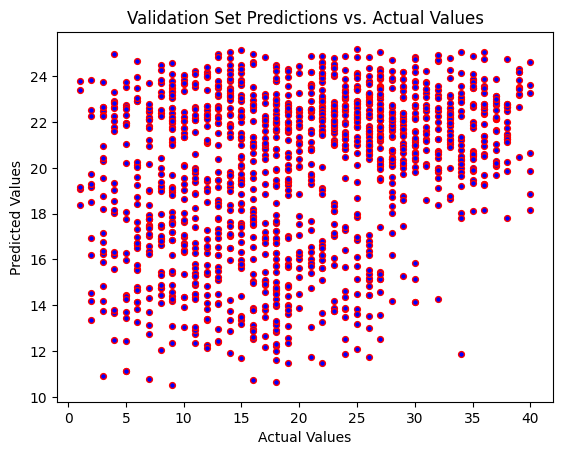

In [50]:
model_pr2 = LinearRegression()
model_performance_trees(model_pr2, 'bike_stands', 'Poly-Regression', X_train_poly, X_test_poly)

In [51]:
bikes = np.vectorize(round_nearest)(model_pr.predict(X_test_poly))
stands = np.vectorize(round_nearest)(model_pr2.predict(X_test_poly))
for i in range(10):
    print(f'Predicted: Bikes={np.round(bikes)[i]}, Bike Stands={np.round(stands)[i]} | Actual: Bikes={np.round(y_test['bikes'].values)[i]}, Bike Stands={np.round(y_test['bike_stands'].values)[i]}')

Predicted: Bikes=12, Bike Stands=21 | Actual: Bikes=9, Bike Stands=27
Predicted: Bikes=13, Bike Stands=21 | Actual: Bikes=13, Bike Stands=27
Predicted: Bikes=8, Bike Stands=15 | Actual: Bikes=8, Bike Stands=21
Predicted: Bikes=12, Bike Stands=22 | Actual: Bikes=26, Bike Stands=14
Predicted: Bikes=12, Bike Stands=24 | Actual: Bikes=11, Bike Stands=29
Predicted: Bikes=13, Bike Stands=21 | Actual: Bikes=4, Bike Stands=16
Predicted: Bikes=11, Bike Stands=17 | Actual: Bikes=17, Bike Stands=13
Predicted: Bikes=10, Bike Stands=15 | Actual: Bikes=3, Bike Stands=17
Predicted: Bikes=13, Bike Stands=23 | Actual: Bikes=24, Bike Stands=16
Predicted: Bikes=12, Bike Stands=25 | Actual: Bikes=8, Bike Stands=32


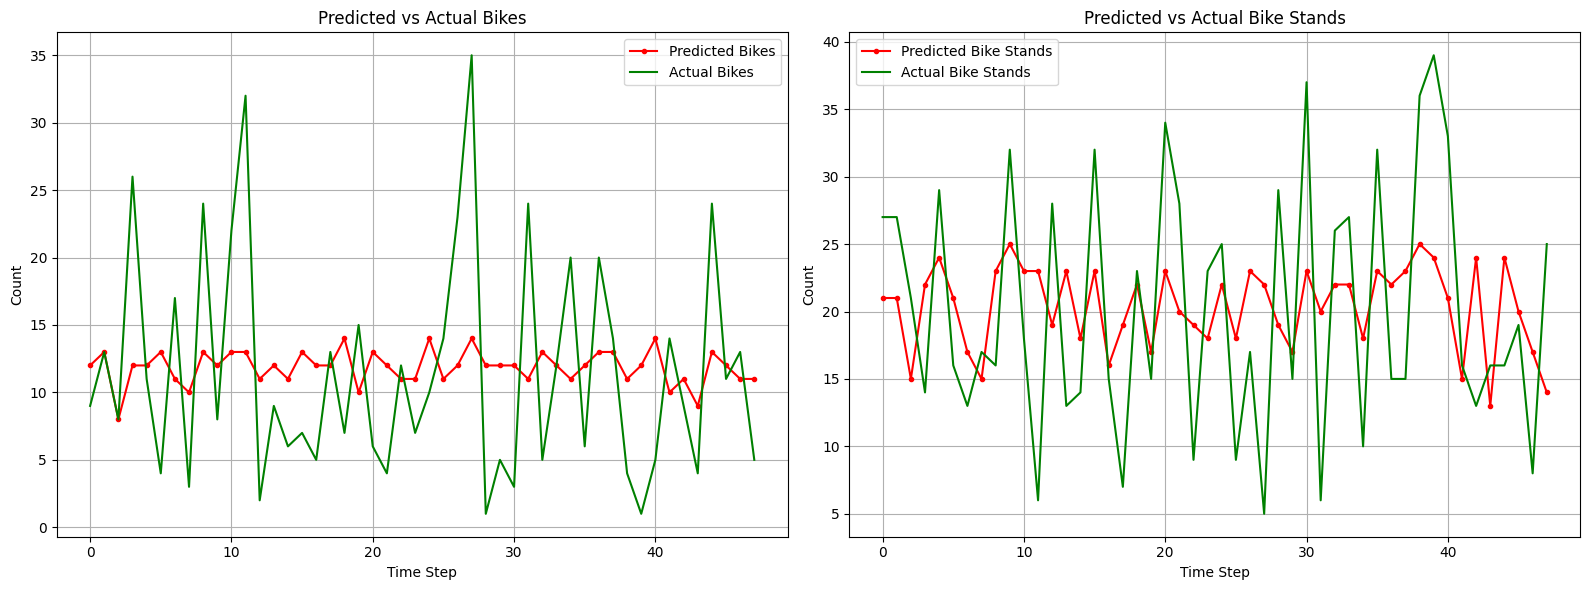

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(np.round(bikes)[:48], label='Predicted Bikes', color='red', marker='.')
axs[0].plot(np.round(y_test['bikes'].values)[:48], label='Actual Bikes', color='green')
axs[0].set_title('Predicted vs Actual Bikes')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(np.round(stands)[:48], label='Predicted Bike Stands', color='red', marker='.')
axs[1].plot(np.round(y_test['bike_stands'].values)[:48], label='Actual Bike Stands', color='green')
axs[1].set_title('Predicted vs Actual Bike Stands')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()

### ANN

In [53]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

In [54]:
preprocessor_ann = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['maxtemp_c', 'mintemp_c', 'avgtemp_c', 'maxwind_kph', 'totalprecip_mm', 'avgvis_km', 'avghumidity', 'uv', 'sunrise', 'sunset', 'date_only', 'day_of_week']),
        ('cat', OneHotEncoder(), ['id'])
    ])
X_train_processed = preprocessor_ann.fit_transform(X_train)
scalar = StandardScaler()
y_train_processed = scalar.fit_transform(y_train.values)

In [55]:
y_train_processed.shape

(5472, 2)

In [56]:
input_shape = X_train_processed.shape[1:]

In [57]:
def model_builder(hp):
    model = Sequential()
    hp_activation1 = hp.Choice('activation', values=['relu', 'tanh'])
    hp_activation2 = hp.Choice('activation', values=['relu', 'tanh'])
    hp_activation3 = hp.Choice('activation', values=['relu', 'tanh'])
    hp_layer_1 = hp.Int('layer_1', min_value=64, max_value=512, step=64)
    hp_layer_2 = hp.Int('layer_2', min_value=64, max_value=512, step=64)
    hp_layer_3 = hp.Int('layer_3', min_value=64, max_value=512, step=64)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.add(Dense(units=hp_layer_1, activation=hp_activation1, input_shape=input_shape))
    model.add(Dense(units=hp_layer_2, activation=hp_activation2))
    model.add(Dense(units=hp_layer_3, activation=hp_activation3))
    model.add(Dense(2))

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mse', metrics=['mean_squared_error'])
    return model

In [58]:
import keras_tuner as kt

objective = kt.Objective('mean_squared_error', direction='min')
tuner = kt.Hyperband(model_builder,
                     objective=objective,
                     max_epochs=50,
                     factor=3,
                     directory='dir',
                     project_name='ann_trials')

In [59]:
tuner.search(X_train_processed.toarray(), y_train_processed, epochs=50, callbacks=[keras.callbacks.EarlyStopping(patience=3)])

Trial 90 Complete [00h 00m 09s]
mean_squared_error: 0.015068620443344116

Best mean_squared_error So Far: 0.010738728567957878
Total elapsed time: 00h 04m 53s


In [60]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [61]:
ann_model = tuner.hypermodel.build(best_hps)
history = ann_model.fit(X_train_processed.toarray(), y_train_processed, epochs=50, callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9387 - mean_squared_error: 0.9387
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4349 - mean_squared_error: 0.4349
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3778 - mean_squared_error: 0.3778
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3725 - mean_squared_error: 0.3725
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3108 - mean_squared_error: 0.3108
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2864 - mean_squared_error: 0.2864
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2355 - mean_squared_error: 0.2355
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2082 - mean_squared_error: 0.2082
Epoch 9/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1908 - mean_squared_error: 0.1908
Epoch 10/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1567 - mean_squared_error: 0.1567
Epoch 11/50
171/171 ━━━━━━━━━━━━━━━━━━━

In [62]:
X_test_processed = preprocessor_ann.transform(X_test)
y_pred = ann_model.predict(X_test_processed.toarray())

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


In [63]:
predictions_inv = scalar.inverse_transform(y_pred)
y_test_inv = y_test.values

predictions_inv= np.vectorize(round_nearest)(predictions_inv)
y_test_inv = np.vectorize(round_nearest)(y_test_inv)

for i in range(10):
    print(f'Predicted: Bikes={predictions_inv[i][0]}, Bike Stands={predictions_inv[i][1]} | Actual: Bikes={y_test_inv[i][0]}, Bike Stands={y_test_inv[i][1]}')

Predicted: Bikes=8, Bike Stands=28 | Actual: Bikes=9, Bike Stands=27
Predicted: Bikes=7, Bike Stands=33 | Actual: Bikes=13, Bike Stands=27
Predicted: Bikes=8, Bike Stands=22 | Actual: Bikes=8, Bike Stands=21
Predicted: Bikes=22, Bike Stands=17 | Actual: Bikes=26, Bike Stands=14
Predicted: Bikes=3, Bike Stands=36 | Actual: Bikes=11, Bike Stands=29
Predicted: Bikes=6, Bike Stands=14 | Actual: Bikes=4, Bike Stands=16
Predicted: Bikes=19, Bike Stands=10 | Actual: Bikes=17, Bike Stands=13
Predicted: Bikes=3, Bike Stands=17 | Actual: Bikes=3, Bike Stands=17
Predicted: Bikes=31, Bike Stands=8 | Actual: Bikes=24, Bike Stands=16
Predicted: Bikes=13, Bike Stands=26 | Actual: Bikes=8, Bike Stands=32


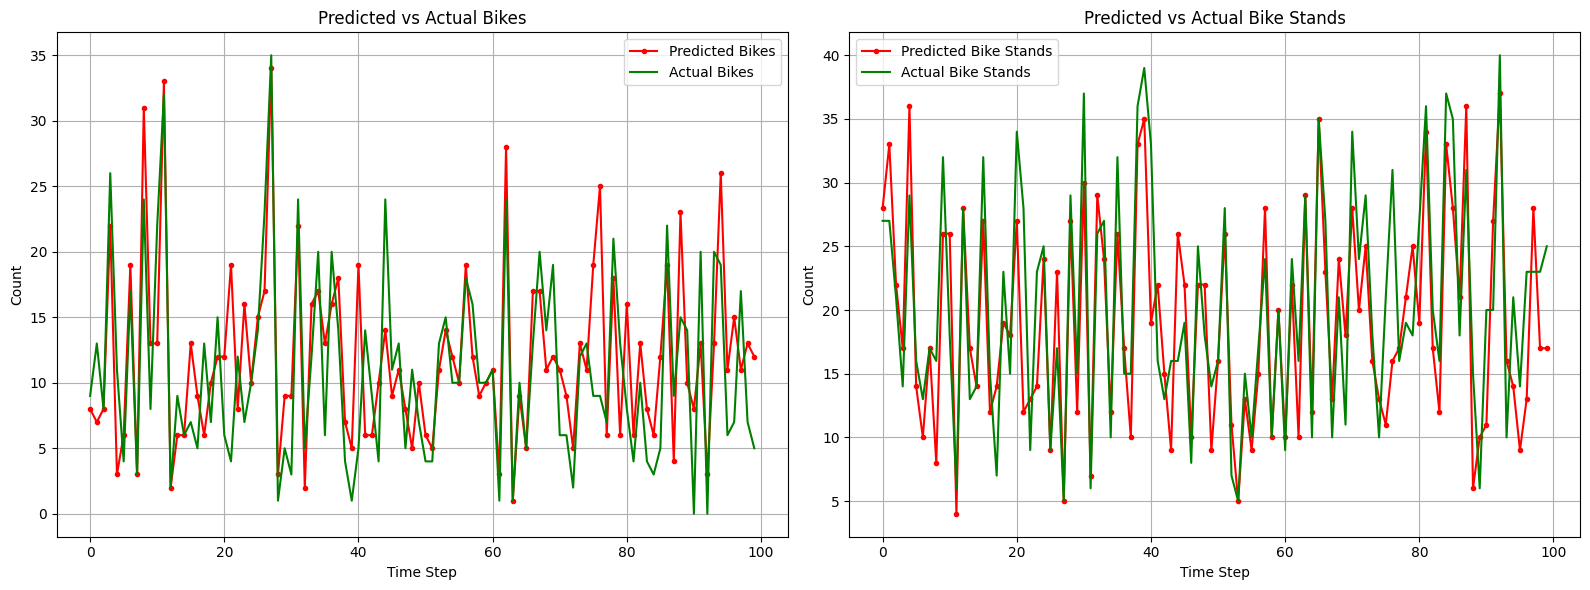

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(predictions_inv[:100, 0], label='Predicted Bikes', color='red', marker='.')
axs[0].plot(y_test_inv[:100, 0], label='Actual Bikes', color='green')
axs[0].set_title('Predicted vs Actual Bikes')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(predictions_inv[:100, 1], label='Predicted Bike Stands', color='red', marker='.')
axs[1].plot(y_test_inv[:100, 1], label='Actual Bike Stands', color='green')
axs[1].set_title('Predicted vs Actual Bike Stands')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [65]:
predict_test = scalar.inverse_transform(y_pred)

mae = mean_absolute_error(y_test, predict_test)
print("MAE : ", mae)
mse = mean_squared_error(y_test, predict_test)
print("MSE : ", mse)
r2 = r2_score(y_test, predict_test)
print("R-squared : ", r2)

MAE :  3.997926714960813
MSE :  26.737949670534555
R-squared :  0.6468670869334213


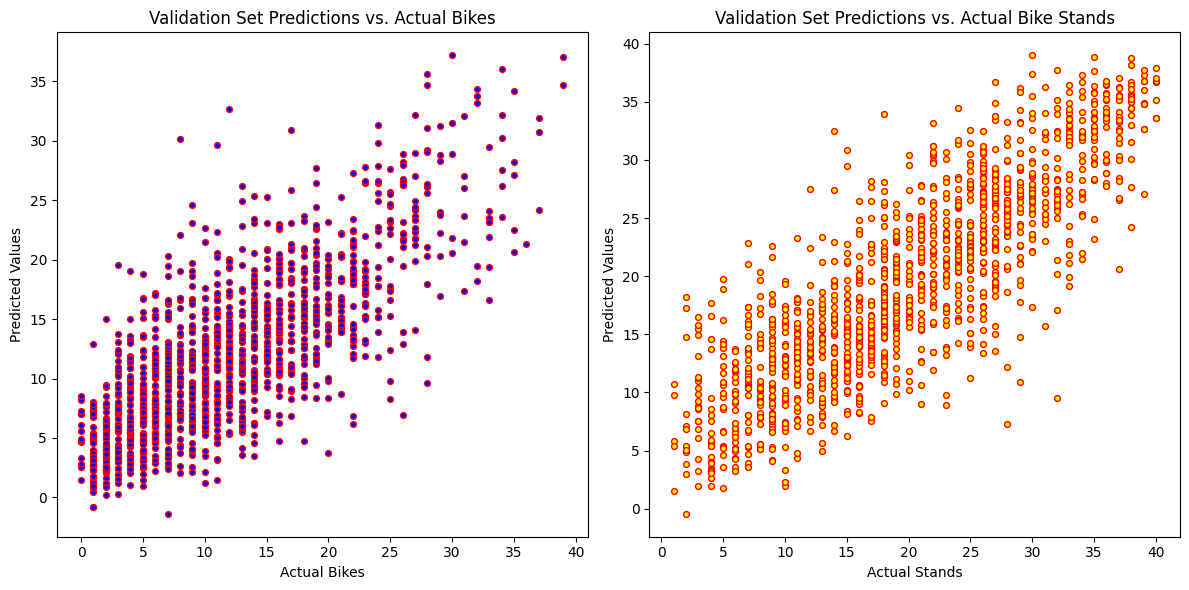

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(y_test['bikes'], predict_test[:, 0], marker='.', color='blue' ,edgecolors='red', s=70)
axs[0].set_xlabel('Actual Bikes')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Validation Set Predictions vs. Actual Bikes')

axs[1].scatter(y_test['bike_stands'], predict_test[:, 1], marker='.', color='yellow' ,edgecolors='red', s=70)
axs[1].set_xlabel('Actual Stands')
axs[1].set_ylabel('Predicted Values')
axs[1].set_title('Validation Set Predictions vs. Actual Bike Stands')

plt.tight_layout()
plt.show()

In [67]:
from datetime import datetime
import requests
import json
import os
from dotenv import load_dotenv
load_dotenv()

link = 'http://api.weatherapi.com/v1/forecast.json'
api = os.getenv('weather_api')
contract = 'Dublin'

response = requests.get(link, 
                        params={"key": api, 
                                "q": contract,
                                'dt': '2024-03-21'})
response.raise_for_status()
now = datetime.now()
data = response.text
data = json.loads(data)

In [68]:
data = pd.json_normalize(data['forecast']['forecastday'][0])

In [69]:

new_data_weather = data[['date_epoch', 'day.maxtemp_c', 'day.mintemp_c','day.avgtemp_c', 'day.maxwind_kph', 'day.totalprecip_mm', 'day.avgvis_km', 'day.avghumidity',  'day.uv', 'astro.sunrise', 'astro.sunset']]
new_data_weather = new_data_weather.rename(columns={
    'date_epoch': 'time_stamp',
    'day.maxtemp_c': 'maxtemp_c',
    'day.mintemp_c': 'mintemp_c',
    'day.avgtemp_c': 'avgtemp_c',
    'day.maxwind_kph': 'maxwind_kph',
    'day.totalprecip_mm': 'totalprecip_mm',
    'day.avgvis_km': 'avgvis_km',
    'day.avghumidity': 'avghumidity',
    'day.uv': 'uv',
    'astro.sunrise': 'sunrise',
    'astro.sunset': 'sunset'
})
new_data_weather['sunrise'] = pd.to_datetime(new_data_weather['sunrise'], format='%I:%M %p')
new_data_weather['sunrise'] = new_data_weather['sunrise'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
new_data_weather['sunset'] = pd.to_datetime(new_data_weather['sunset'], format='%I:%M %p')
new_data_weather['sunset'] = new_data_weather['sunset'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

new_data_weather['time_stamp'] = pd.to_datetime(new_data_weather['time_stamp'], unit='s').dt.round('D')

In [70]:
new_data_weather['time_stamp'].unique()

<DatetimeArray>
['2024-03-21 00:00:00']
Length: 1, dtype: datetime64[ns]

In [71]:
link = 'https://api.jcdecaux.com/vls/v1/stations'
api = os.getenv('db_api')
contract = 'Dublin'

response = requests.get(link, 
                        params={"apiKey": api, 
                                "contract": contract})
response.raise_for_status()
now = datetime.now()
data = response.text
data = json.loads(data)
data = pd.json_normalize(data)
data.sort_values(by='number', inplace=True)
data.head()

,number,contract_name,name,address,banking,bonus,bike_stands,available_bike_stands,available_bikes,status,last_update,position.lat,position.lng
16,1,dublin,CLARENDON ROW,Clarendon Row,False,False,31,28,3,OPEN,1710948717000,53.340927,-6.262501
83,2,dublin,BLESSINGTON STREET,Blessington Street,False,False,20,18,2,OPEN,1710948206000,53.356769,-6.268140
104,3,dublin,BOLTON STREET,Bolton Street,False,False,20,14,6,OPEN,1710948271000,53.351182,-6.269859
44,4,dublin,GREEK STREET,Greek Street,False,False,20,0,20,OPEN,1710948350000,53.346874,-6.272976
39,5,dublin,CHARLEMONT PLACE,Charlemont Street,False,False,40,39,1,OPEN,1710948756000,53.330662,-6.260177


In [72]:
new_data_bike = data[['last_update', 'number']]
new_data_bike = new_data_bike.rename(columns={'last_update': 'time_stamp', 'number': 'id'})
new_data_bike['time_stamp'] = pd.to_datetime(new_data_bike['time_stamp'], unit='ms').dt.round('D')

In [73]:
new_data = pd.merge(new_data_bike, new_data_weather, on='time_stamp', how='inner')
new_data['time_stamp'] = pd.to_datetime(new_data['time_stamp'])
new_data['date_only'] = new_data['time_stamp'].dt.day
new_data['day_of_week'] = new_data['time_stamp'].dt.dayofweek
new_data['time_stamp'] = (pd.to_datetime(new_data['time_stamp']).astype(int) / 10**9).astype(int)
new_data = new_data.drop('time_stamp', axis=1)
new_data.head()

,id,maxtemp_c,mintemp_c,avgtemp_c,maxwind_kph,totalprecip_mm,avgvis_km,avghumidity,uv,sunrise,sunset,date_only,day_of_week
0,1,13.4,3.8,9.6,21.2,0.68,9.3,77,3.0,23040,67260,21,3
1,2,13.4,3.8,9.6,21.2,0.68,9.3,77,3.0,23040,67260,21,3
2,3,13.4,3.8,9.6,21.2,0.68,9.3,77,3.0,23040,67260,21,3
3,4,13.4,3.8,9.6,21.2,0.68,9.3,77,3.0,23040,67260,21,3
4,5,13.4,3.8,9.6,21.2,0.68,9.3,77,3.0,23040,67260,21,3


In [74]:
X_sample = preprocessor_ann.transform(new_data)
pred = ann_model.predict(X_sample.toarray())

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [75]:
y_true = pd.DataFrame()
y_true = data[['available_bike_stands', 'available_bikes', 'number']]
y_true.sort_values(by='number', inplace=True)
y_true.set_index('number', inplace=True)
y_true.head()

,available_bike_stands,available_bikes
number,,
1,28,3
2,18,2
3,14,6
4,0,20
5,39,1


In [76]:
pred_inv = scalar.inverse_transform(pred)
pred_inv = np.vectorize(round_nearest)(pred_inv)
for i in range(10):
    print(f'Predicted: Bikes={pred_inv[i][0]}, Bike Stands={pred_inv[i][1]} | Actual: Bikes={y_true['available_bikes'].values[i]}, Bike Stands={y_true['available_bike_stands'].values[i]}')

Predicted: Bikes=11, Bike Stands=21 | Actual: Bikes=3, Bike Stands=28
Predicted: Bikes=4, Bike Stands=16 | Actual: Bikes=2, Bike Stands=18
Predicted: Bikes=6, Bike Stands=13 | Actual: Bikes=6, Bike Stands=14
Predicted: Bikes=11, Bike Stands=9 | Actual: Bikes=20, Bike Stands=0
Predicted: Bikes=23, Bike Stands=18 | Actual: Bikes=1, Bike Stands=39
Predicted: Bikes=3, Bike Stands=16 | Actual: Bikes=3, Bike Stands=17
Predicted: Bikes=7, Bike Stands=19 | Actual: Bikes=0, Bike Stands=29
Predicted: Bikes=18, Bike Stands=11 | Actual: Bikes=10, Bike Stands=20
Predicted: Bikes=6, Bike Stands=19 | Actual: Bikes=19, Bike Stands=5
Predicted: Bikes=12, Bike Stands=3 | Actual: Bikes=15, Bike Stands=1


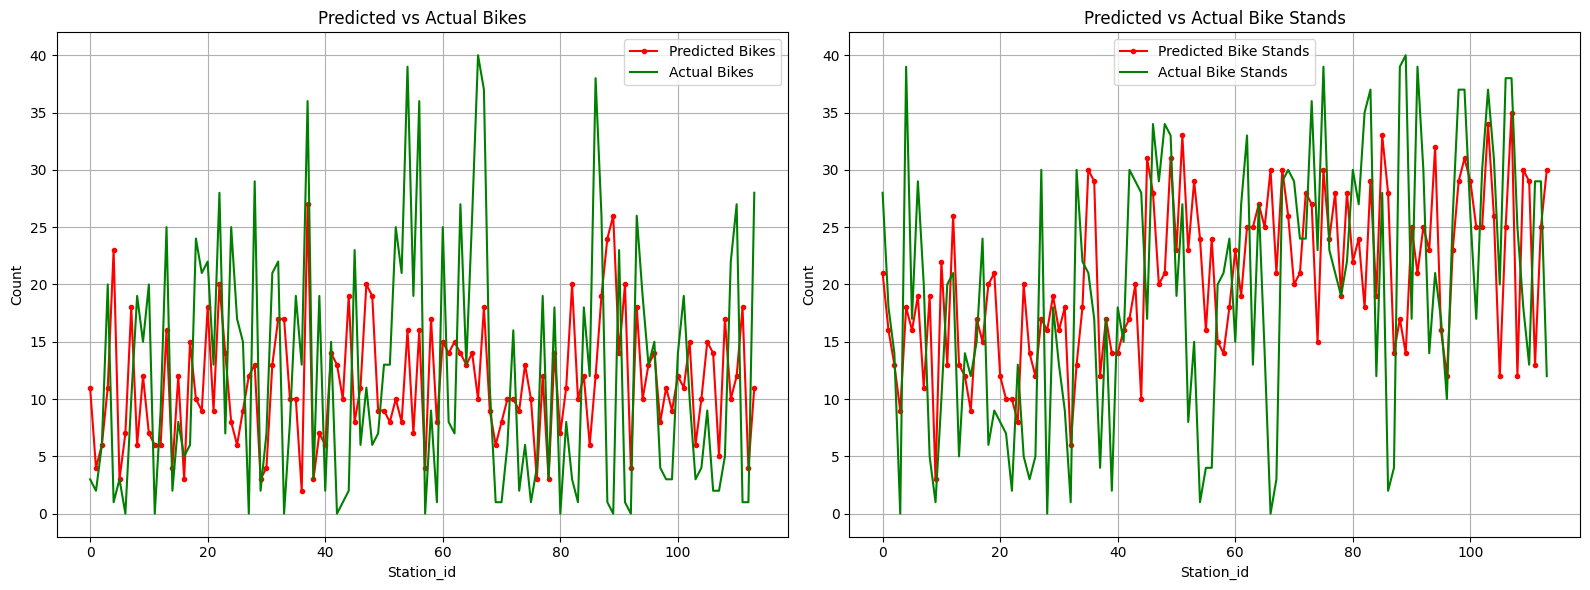

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(pred_inv[:, 0], label='Predicted Bikes', color='red', marker='.')
axs[0].plot(y_true['available_bikes'].values, label='Actual Bikes', color='green')
axs[0].set_title('Predicted vs Actual Bikes')
axs[0].set_xlabel('Station_id')
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(pred_inv[:, 1], label='Predicted Bike Stands', color='red', marker='.')
axs[1].plot(y_true['available_bike_stands'].values, label='Actual Bike Stands', color='green')
axs[1].set_title('Predicted vs Actual Bike Stands')
axs[1].set_xlabel('Station_id')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()